# Articence - Assignment 1
## Miguel Miguélez Díaz
**"Suggest which products should be dropped from selling in the next year moving forward and which products should be sold more. Should any region be given preference over the other?"**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
csv_dir = "Data Science Evaluation.csv"

# Create function to measure model accuracy
def acc_metrics(model_name, error, test_y, pred_y):
    # Calculate mean absolute error (MAE)
    mae = round(np.mean(error), 2)
    print("\n", model_name, ": MAE: ", mae, 'units')
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (error / test_y)
    # Calculate accuracy
    accuracy = 100 - np.mean(mape)
    print(model_name, ": Accuracy:", round(accuracy, 2), "%")
    # Calculate R2 Score
    r = r2_score(test_y, pred_y)
    print(model_name, ": R2 Score:", r)
    return accuracy

# Reverse one-hot encoding (using function from https://stackoverflow.com/a/62085741/15457615)
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

## Exploratory Data Analysis
### Read and take a look at the data

In [2]:
# Read csv file
df = pd.read_csv(csv_dir)
# Take a look at the first rows to ensure correct read
print(df.head(10))
# check if missing values and column types
print(df.info()) # No missing values

                              Region        Country        Item Type  \
0                 Sub-Saharan Africa  Cote d'Ivoire           Snacks   
1                 Sub-Saharan Africa       Ethiopia           Snacks   
2  Central America and the Caribbean         Panama          Clothes   
3                             Europe         Sweden  Office Supplies   
4                             Europe        Romania        Cosmetics   
5                               Asia       Maldives        Beverages   
6                 Sub-Saharan Africa       Tanzania        Beverages   
7              Australia and Oceania          Tonga          Clothes   
8       Middle East and North Africa       Pakistan          Clothes   
9                 Sub-Saharan Africa           Chad        Household   

   Fiscal Year Sales Channel Order Priority Order Date   Order ID Ship Date  \
0         2010        Online              C    4/23/10  241891753   4/26/10   
1         2010        Online              H     6

### Plot units sold by product

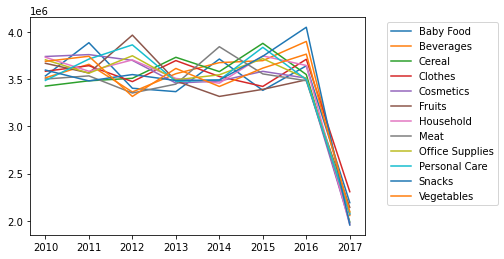

In [3]:
# EDA
# Create plot: units sold grouped by product for every year
fig, ax = plt.subplots()
df_plot = df.groupby(['Item Type', 'Fiscal Year']).agg({'Units Sold':'sum'}).reset_index()
df_plot["'Fiscal Year'"] = pd.to_datetime(df_plot['Fiscal Year'], format='%Y')
df_plot.reset_index(drop=True, inplace=True)
# Plot each label
for label, grp in df_plot.groupby('Item Type'):
    ax.plot(df_plot[df_plot['Item Type']==label]["Fiscal Year"], df_plot[df_plot['Item Type']==label]["Units Sold"], label=label)
# Add legend
ax.legend(bbox_to_anchor=(1.05, 1))


We can observe a drop in 2017 sales for every single product.

### Plot units sold by region
This way, we try to find out the cause for the sudden drop in units sold:

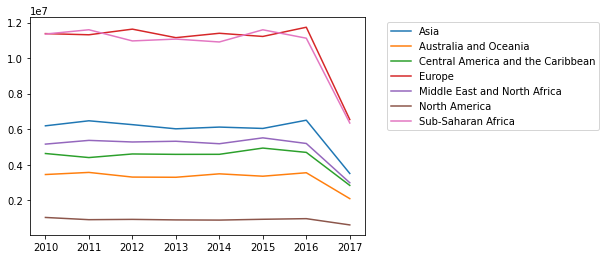

In [4]:
# Create plot: units sold grouped by products for every year
fig, ax = plt.subplots()
df_plot = df.groupby(['Region', 'Fiscal Year']).agg({'Units Sold':'sum'}).reset_index()
df_plot["'Fiscal Year'"] = pd.to_datetime(df_plot['Fiscal Year'], format='%Y')
df_plot.reset_index(drop=True, inplace=True)
# Plot each label
for label, grp in df_plot.groupby('Region'):
    ax.plot(df_plot[df_plot['Region']==label]["Fiscal Year"], df_plot[df_plot['Region']==label]["Units Sold"], label=label)
# Add legend
ax.legend(bbox_to_anchor=(1.05, 1))

Europe and Sub-Saharan Africa region take up a big part of the decline in sales. No region grew in 2017.

### Plot total profit by product
We'll assess if the biggest drop in sales has been produced in units whose profitability is small:

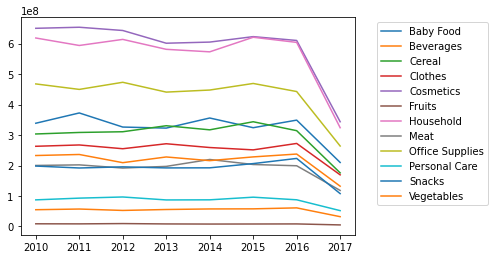

In [38]:
# Create plot: units sold grouped by region for every year
fig, ax = plt.subplots()
df_plot = df.groupby(['Item Type', 'Fiscal Year']).agg({'Total Profit':'sum'}).reset_index()
df_plot["'Fiscal Year'"] = pd.to_datetime(df_plot['Fiscal Year'], format='%Y')
df_plot.reset_index(drop=True, inplace=True)
# Plot each label
for label, grp in df_plot.groupby('Item Type'):
    ax.plot(df_plot[df_plot['Item Type']==label]["Fiscal Year"], df_plot[df_plot['Item Type']==label]["Total Profit"], label=label)
# Add legend
ax.legend(bbox_to_anchor=(1.05, 1))

### Plot total profit by region
We'll assess if the biggest drop in sales has been produced in regions whose profitability is small:

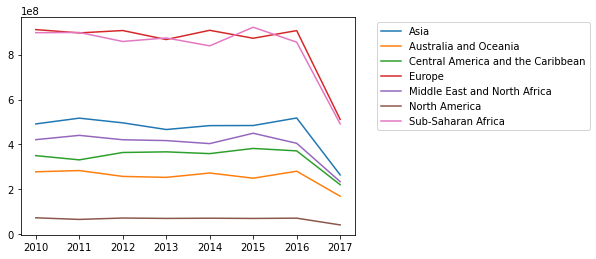

In [5]:
# Create plot: units sold grouped by region for every year
fig, ax = plt.subplots()
df_plot = df.groupby(['Region', 'Fiscal Year']).agg({'Total Profit':'sum'}).reset_index()
df_plot["'Fiscal Year'"] = pd.to_datetime(df_plot['Fiscal Year'], format='%Y')
df_plot.reset_index(drop=True, inplace=True)
# Plot each label
for label, grp in df_plot.groupby('Region'):
    ax.plot(df_plot[df_plot['Region']==label]["Fiscal Year"], df_plot[df_plot['Region']==label]["Total Profit"], label=label)
# Add legend
ax.legend(bbox_to_anchor=(1.05, 1))

### EDA Conclusions
* There is a sudden drop in sales in 2017. Total profits also took a big hit in 2017 as a result of this drop in sales.
* This drop in sales cannot be explained by looking at a single product or region. It happens at every level and it hinders 2017 profits. However, the drop in Europe and Sub-Saharian Africa looks like the most important one.
* Without further information, we have to make assumptions. My assumption is that the drop in sales is caused by problems with the supply. The company couldn't match the demand for unknown issues.
* That is why they are asking us which products should be sold more and which should be dropped (to prioritize supply).
* We will predict the sales for the year 2017 (last year with data) and see the gap between the actual number of units sold and the predicted ones. Then, we will check which products could have been sold more and, looking at the profitability, make a recommendation about which ones are a priority (similar for those that are not a priority).
* A similar analysis with regions will be done.

## Data Preparation
* Prepare data to predict total sales by region and product.
* Some of the columns from the raw data cannot be used as predictors, because they don't affect the customer decision of buying or not. 
* Look for new regressors to generate reliable predictions:
  * Previous year sales: this is a time series and therefore each year sales depends on last year sales. `units_sold_lag_1`
  * Days between order date and ship date in the past year (the client might not repeat if times are long). `days_to_process_lag_1`
* Transform categorical variables into one-hot encoding so the model can process these features.
* This is a time series problem, so we cannot use k-fold cross validation. We will use 2016 as our test data, and the previous years as our training data.

In [9]:
# Data Preparation
# Count days between order/ship dates
df['days_to_process'] = (pd.to_datetime(df['Ship Date']) - pd.to_datetime(df['Order Date'])).dt.days

# Only keep important columns for prediction of next year sales
# We remove channel so we don't have to aggregate by this category too
# These should not be a predictor of sales: Unit Cost, 'Total Cost', Total Revenue, Profit as % of Cost 
# but they will be important to decide which ones should be sold more
cols_2_drop = ['Sales Channel', 'Order Priority', 'Order Date', 'Order ID', 'Ship Date', 'Unit Cost', 'Total Revenue','Total Cost', 'Total Profit', 'Profit as % of Cost']
df_pred = df.drop(columns=cols_2_drop)

# Aggregate data of the same year/region/country/item type
# add: Units Sold, 
# mean: Unit Price, 
d = {'Units Sold':'sum', 'Unit Price':'mean', 'days_to_process':'mean'} 
grouped_cols = ['Region', 'Item Type', 'Fiscal Year']
df_pred = df_pred.groupby(by=grouped_cols).agg(d).reset_index() 
# Sliding window: add previous year sales so the model is aware of the increase across consecutive years
df_pred["units_sold_lag_1"] = df_pred.groupby(['Region', 'Item Type'])["Units Sold"].shift(1)
df_pred["days_to_process_lag_1"] = df_pred.groupby(['Region', 'Item Type'])["days_to_process"].shift(1)
df_pred["days_to_process_lag_1"] = round(df_pred["days_to_process_lag_1"], 0)
df_pred.dropna(axis=0, inplace = True)

# Categorical columns to one-hot encoding
cat_features = ["Region", "Item Type"] 
predictors = pd.get_dummies(df_pred, columns = cat_features)
predictors = predictors.drop(columns=['Units Sold', "days_to_process"])
# Target variable
target = df_pred['Units Sold']

# Split train/test:
# cv=1 -> randomly select test + train samples; only to initially test. Can't use it for a time series
# cv=0 -> divide out depending on year (test time series behavior)
cv = 0
if cv: # DON'T USE for this example as it's a time series problem. Only to quickly check models
    train_x, test_x, train_y, test_y = train_test_split(predictors, target, test_size = 0.25, random_state = 1)
else:
    is_2016 =  predictors['Fiscal Year'] == 2016 
    # Exclude 2017 from analysis
    pre_2016 =  predictors['Fiscal Year'] < 2016 
    predictors_wo_year = predictors.drop(columns=["Fiscal Year"])
    train_x = predictors_wo_year[pre_2016 == True]
    test_x = predictors_wo_year[is_2016 == True]
    train_y = target[pre_2016 == True]
    test_y = target[is_2016 == True]

## Train and test models
We will consider the following models:
* Random Forest
* Linear regression
* Lasso

We will test the models with and without the `days_to_process_lag_1` regressor. To measure the precision of the model, we will use the mean absolute error (MAE), accuracy as (100 -  MAPE) %, and the R2 score.

In [7]:
# Fit linear regression models and random forest and compare results
# Train and test models with days_to_process_lag_1 variable

# Random Forest
rf = RandomForestRegressor(n_estimators = 1000, random_state = 1)
rf.fit(train_x, train_y)
rf_pred_y = rf.predict(test_x)
rf_error = abs(rf_pred_y - test_y)
# Show accuracy metrics
rf_acc = acc_metrics("rf", rf_error, test_y, rf_pred_y)

# Linear Regression
lr = LinearRegression()
lr.fit(train_x, train_y)
lr_pred_y = lr.predict(test_x)
lr_error = abs(lr_pred_y - test_y)
# Show accuracy metrics
lr_acc = acc_metrics("lr", lr_error, test_y, lr_pred_y)

# Lasso
lasso = Lasso()
lasso.fit(train_x, train_y)
lasso_pred_y = lasso.predict(test_x)
lasso_error = abs(lasso_pred_y - test_y)
# Show accuracy metrics
lasso_acc = acc_metrics("lasso", lasso_error, test_y, lasso_pred_y)

# Train and test models WITHOUT days_to_process_lag_1 variable
train_x_2 = train_x.drop(columns = "days_to_process_lag_1")
test_x_2 = test_x.drop(columns = "days_to_process_lag_1")
# Random Forest
rf_2 = RandomForestRegressor(n_estimators = 1000, random_state = 1)
rf_2.fit(train_x_2, train_y)
rf_2_pred_y = rf_2.predict(test_x_2)
rf_2_error = abs(rf_2_pred_y - test_y)
# Show accuracy metrics
rf_2_acc = acc_metrics("rf_2", rf_2_error, test_y, rf_2_pred_y)

# Linear Regression
lr_2 = LinearRegression()
lr_2.fit(train_x_2, train_y)
lr_2_pred_y = lr_2.predict(test_x_2)
lr_2_error = abs(lr_2_pred_y - test_y)
# Show accuracy metrics
lr_2_acc = acc_metrics("lr_2", lr_2_error, test_y, lr_2_pred_y)

# Lasso
lasso_2 = Lasso()
lasso_2.fit(train_x_2, train_y)
lasso_2_pred_y = lasso_2.predict(test_x_2)
lasso_2_error = abs(lasso_2_pred_y - test_y)
# Show accuracy metrics
lasso_2_acc = acc_metrics("lasso_2", lasso_2_error, test_y, lasso_2_pred_y)



 rf : MAE:  53171.87 units
rf : Accuracy: 85.81 %
rf : R2 Score: 0.9482318716113622

 lr : MAE:  49815.29 units
lr : Accuracy: 87.8 %
lr : R2 Score: 0.953512131257792

 lasso : MAE:  49815.52 units
lasso : Accuracy: 87.8 %
lasso : R2 Score: 0.9535147184969209
C:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59704038611.055786, tolerance: 3919005102.566419
  model = cd_fast.enet_coordinate_descent(

 rf_2 : MAE:  53650.11 units
rf_2 : Accuracy: 85.73 %
rf_2 : R2 Score: 0.9467814898598751

 lr_2 : MAE:  49732.93 units
lr_2 : Accuracy: 87.97 %
lr_2 : R2 Score: 0.953393860327638

 lasso_2 : MAE:  49731.98 units
lasso_2 : Accuracy: 87.97 %
lasso_2 : R2 Score: 0.9533964452464775
C:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of itera

Checking all the metrics, the best model is Lasso and the regressor `days_to_process_lag_1` does not improve the accuracy.

## Prediction
We'll be predicting 2017 sales so we can compare the results with the actual sales in 2017. Those products with a bigger gap between what was predicted and the actual sales will be taken into account along with its profitability. After this, we'll suggest with products should be dropped in the next year, as well as those that should be sold more. We'll perform a similar analysis regarding the different regions.

In [10]:
# Select model with more accuracy, include 2016 sales and predict sales for 2017
model = Lasso()
is_2017 = predictors["Fiscal Year"] == 2017
predictors_reduced = predictors.drop(columns=["Fiscal Year", "days_to_process_lag_1"])
model.fit(predictors_reduced[is_2017 == False], target[is_2017 == False])

# Create predictors matrix for 2017
future_pred = df_pred.drop(columns=["Fiscal Year", "Units Sold", "days_to_process", "days_to_process_lag_1", "units_sold_lag_1"])
future_pred["Unit Price"] = round(future_pred["Unit Price"], 2)
future_pred.drop_duplicates(inplace=True, ignore_index=True)
# Add units sold lag 1 (2016)
sales_2016 = df_pred[df_pred["Fiscal Year"]==2016][["Units Sold", "Item Type", "Region"]].rename(columns={"Units Sold": "units_sold_lag_1"})
future_pred = pd.merge(future_pred, sales_2016, on=cat_features)
future_pred = pd.get_dummies(future_pred, columns = cat_features)

# Predict sales
next_year_y = model.predict(future_pred)
# Add vector of predictions to dataframe
next_year_y = pd.concat([future_pred, pd.DataFrame(next_year_y, columns = ["Units Sold Pred"])], axis=1)
# Only an integer number of units can be sold
next_year_y["Units Sold Pred"] = round(next_year_y["Units Sold Pred"], 0)
next_year_y_cat = undummify(next_year_y.drop(columns="units_sold_lag_1"))

C:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 840885826597.8318, tolerance: 4726104400.740556
  model = cd_fast.enet_coordinate_descent(


In [12]:
# Add actual results for 2017
sales_2017 = df_pred[df_pred["Fiscal Year"]==2017][["Units Sold", "Item Type", "Region"]]
pred_and_real_2017 = pd.merge(next_year_y_cat, sales_2017, on=cat_features)
pred_and_real_2017["Potential Sales"] = pred_and_real_2017["Units Sold Pred"] - pred_and_real_2017["Units Sold"]

# Calculate profits for each region/product
# Get costs by product (same cost any region) to calculate profits
summary_cost = df.loc[:, ["Item Type", 'Unit Cost']]
summary_cost.drop_duplicates(inplace=True, ignore_index=True)
# Join with next year predictions sales_2017
summary_2017 = pd.merge(pred_and_real_2017, summary_cost, on='Item Type')
# Potential Cost, revenue, profit metrics for 2017
summary_2017['Total Cost'] = summary_2017['Unit Cost'] * summary_2017['Potential Sales']
summary_2017['Total Revenue'] = summary_2017['Unit Price'] * summary_2017['Potential Sales'] 
summary_2017['Total Profit'] = summary_2017['Total Revenue'] - summary_2017['Total Cost']
summary_2017['Profit as % of Cost'] = summary_2017['Total Profit'] / summary_2017['Total Cost']

# Final Analysis
* Which products could potentially contribute more (and less) to the total profit of the company?
* Which regions could potentially contribute more to the profit of the company?
* Top 5 (and bottom 5) tuple product/region with most potential missed profit opportunity
* Easiest items to make profit from (best profit as a percentage of cost ratio)


### Potential Missed Profit Opportunities in 2017 by Item

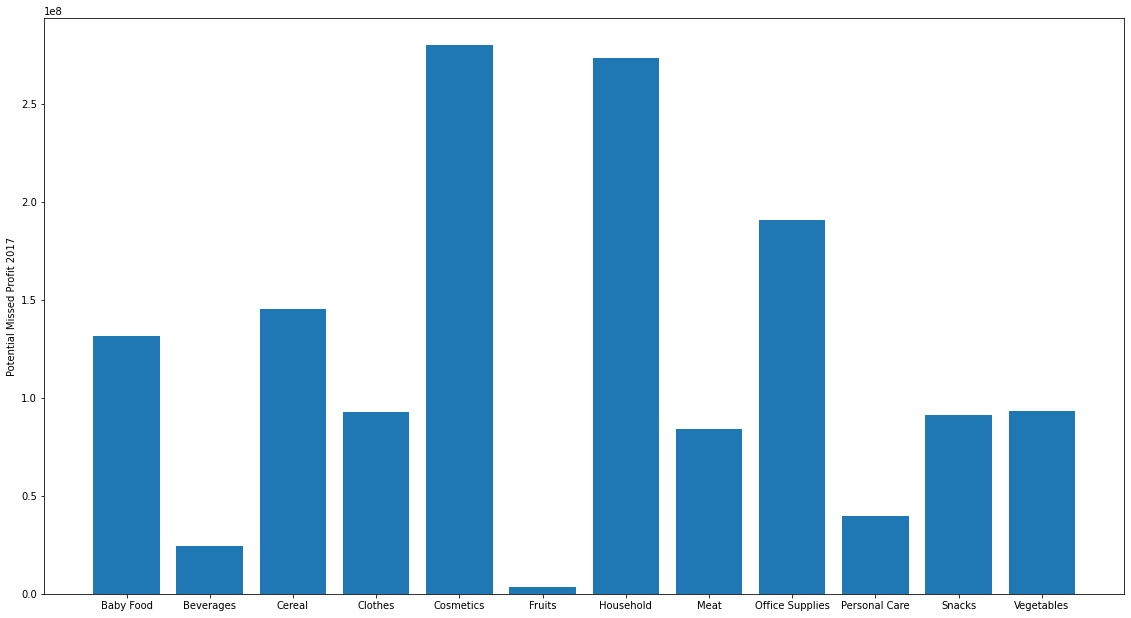

In [33]:
# Data to plot
bar_plot_profits_prod = summary_2017.groupby(["Item Type"]).agg({"Total Profit": "sum"}).reset_index()

# Plot
fig = plt.figure(1, [15, 8])
ax = fig.add_axes([0,0,1,1])
ax.bar(bar_plot_profits_prod["Item Type"], bar_plot_profits_prod["Total Profit"])
plt.ylabel("Potential Missed Profit 2017")
plt.show()

In [56]:
# Calculate percentage of Cosmetics and Household missed profit over total missed profit (top)
is_cosmetic = bar_plot_profits_prod["Item Type"] == "Cosmetics"
is_househ = bar_plot_profits_prod["Item Type"] == "Household"
missed_cosm_househ = 100*(bar_plot_profits_prod[is_cosmetic]["Total Profit"].sum() + bar_plot_profits_prod[is_househ]["Total Profit"].sum()) / bar_plot_profits_prod["Total Profit"].sum()
print("Cosmetic and Household share in potential missed profit:", round(missed_cosm_househ,1), "%")

# Calculate percentage of Fruits and Beverages missed profit over total missed profit (bottom)
is_fruits = bar_plot_profits_prod["Item Type"] == "Fruits"
is_bever = bar_plot_profits_prod["Item Type"] == "Beverages"
missed_cosm_househ = 100*(bar_plot_profits_prod[is_fruits]["Total Profit"].sum() + bar_plot_profits_prod[is_bever]["Total Profit"].sum()) / bar_plot_profits_prod["Total Profit"].sum()
print("Beverages and Fruits share in potential missed profit:", round(missed_cosm_househ,1), "%")

Cosmetic and Household share in potential missed profit: 38.2 %
Cosmetic and Fruits share in Beverages missed profit: 1.9 %


### Potential Missed Profit Opportunities in 2017 by Region

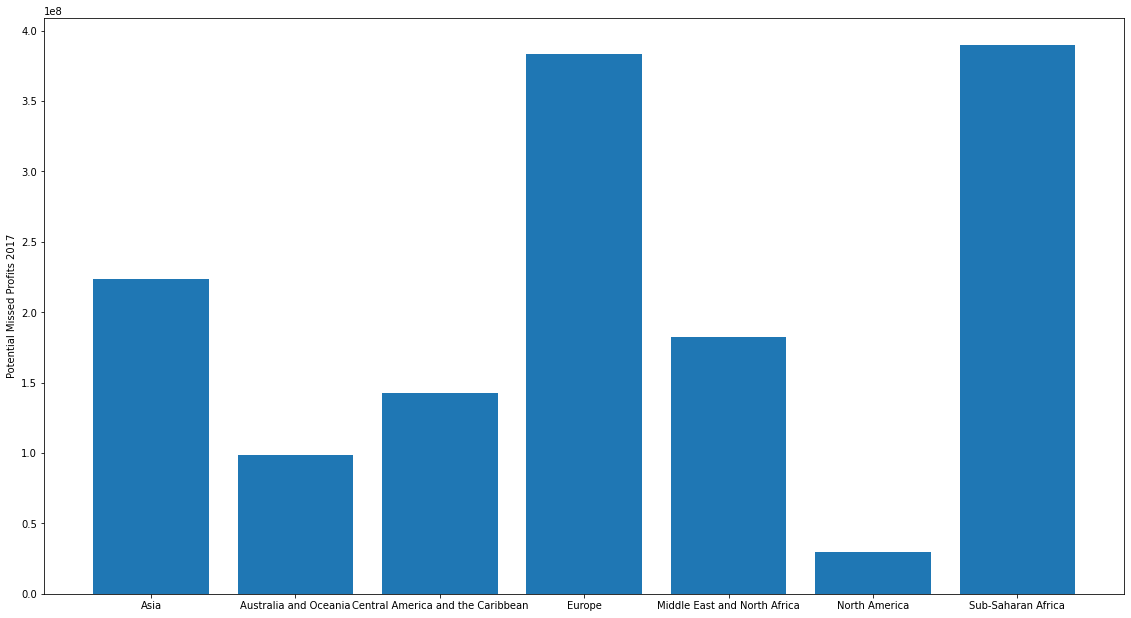

In [34]:
# Data to plot
bar_plot_profits_reg = summary_2017.groupby(["Region"]).agg({"Total Profit": "sum"}).reset_index()

# Plot
fig = plt.figure(1, [15, 8])
ax = fig.add_axes([0,0,1,1])
ax.bar(bar_plot_profits_reg["Region"], bar_plot_profits_reg["Total Profit"])
plt.ylabel("Potential Missed Profits 2017")
plt.show()

In [57]:
# Calculate percentage of Europe and Sub-Saharan Africa missed profit over total missed profit (top 2)
is_europe = bar_plot_profits_reg["Region"] == "Europe"
is_subsah = bar_plot_profits_reg["Region"] == "Sub-Saharan Africa"
missed_eur_ss = 100*(bar_plot_profits_reg[is_europe]["Total Profit"].sum() + bar_plot_profits_reg[is_subsah]["Total Profit"].sum()) / bar_plot_profits_reg["Total Profit"].sum()
print("Europe and Sub-Saharan Africa share in potential missed profit:", round(missed_eur_ss,1), "%")

# Calculate percentage of Australia and Oceania and North America missed profit over total missed profit (bottom 2)
is_northam = bar_plot_profits_reg["Region"] == "North America"
is_aust = bar_plot_profits_reg["Region"] == "Australia and Oceania"
missed_am_aust= 100*(bar_plot_profits_reg[is_northam]["Total Profit"].sum() + bar_plot_profits_reg[is_aust]["Total Profit"].sum()) / bar_plot_profits_reg["Total Profit"].sum()
print("North America and Australia and Oceania share in potential missed profit:", round(missed_am_aust,1), "%")

Europe and Sub-Saharan Africa share in potential missed profit: 53.3 %
North America and Australia and Oceania share in potential missed profit: 8.9 %


### Top 5 Potential Missed Profit Opportunities by Product and Region

In [35]:
# Select top 5 products/region with most potential missed sales oportunities
summary_2017.sort_values(by="Total Profit", ascending=False).head(5)

,Unit Price,Region,Item Type,Units Sold Pred,Units Sold,Potential Sales,Unit Cost,Total Cost,Total Revenue,Total Profit,Profit as % of Cost
48,668.27,Sub-Saharan Africa,Household,935982.0,437529,498453.0,502.54,2.504926e+08,3.331012e+08,82608615.69,0.329785
34,437.20,Sub-Saharan Africa,Cosmetics,935034.0,469174,465860.0,263.33,1.226749e+08,2.036740e+08,80999078.20,0.660274
31,437.20,Europe,Cosmetics,951029.0,535928,415101.0,263.33,1.093085e+08,1.814822e+08,72173610.87,0.660274
45,668.27,Europe,Household,953504.0,544160,409344.0,502.54,2.057117e+08,2.735523e+08,67840581.12,0.329785
59,651.21,Europe,Office Supplies,947685.0,528247,419438.0,524.96,2.201882e+08,2.731422e+08,52954047.50,0.240495


### Bottom 5 Potential Missed Profit Opportunities by Product and Region in 2017
We can observe that only two products were sold more than what it was predicted. These two products are baby food and fruits in the region of North America.

In [36]:
# Select bottom 5 products/region with most potential missed sales oportunities
summary_2017.sort_values(by="Total Profit", ascending=True).head(5)

,Unit Price,Region,Item Type,Units Sold Pred,Units Sold,Potential Sales,Unit Cost,Total Cost,Total Revenue,Total Profit,Profit as % of Cost
5,255.28,North America,Baby Food,72498.0,76811,-4313.0,159.42,-687578.46,-1101022.64,-413444.18,0.601305
40,9.33,North America,Fruits,67584.0,110780,-43196.0,6.92,-298916.32,-403018.68,-104102.36,0.348266
26,109.28,North America,Clothes,76101.0,74530,1571.0,35.84,56304.64,171678.88,115374.24,2.049107
36,9.33,Australia and Oceania,Fruits,279007.0,194808,84199.0,6.92,582657.08,785576.67,202919.59,0.348266
39,9.33,Middle East and North Africa,Fruits,433480.0,340078,93402.0,6.92,646341.84,871440.66,225098.82,0.348266


### Profit as a Percentage of Cost by Product 
The data are identical across different regions.

In [32]:
# Easiest items to make profit from (descending order)
summary_2017.groupby(["Item Type"]).agg({"Profit as % of Cost" : "mean"}).drop_duplicates().sort_values(by="Profit as % of Cost", ascending=False)

,Profit as % of Cost
Item Type,
Clothes,2.049107
Cereal,0.756468
Vegetables,0.694270
Cosmetics,0.660274
Baby Food,0.601305
Snacks,0.565887
Beverages,0.492608
Personal Care,0.442209
Fruits,0.348266


# Conclusion
The products that should be sold more are Cosmetics, Household, and Clothes. Cosmetics and household products represent more than a 38% of the total missed profit for 2017. We acknowledge that household products have a small profit as of percentage of cost ratio, but we cannot reduce the sales of this product as it's a key part in our total profit. Regarding clothes, it's the one with the highest product margin. Therefore, a boost in clothes sales is recommended.

On the other hand, the products that should be sold dropped going forward are fruits and beverages. They only represent about a 2% of the missed profit in 2017, but they were also the products that reported less profit in previous years. Their product margin is not high either.

Regarding region preferences, Europe and Sub-Saharan Africa should have high priority as they represent 53.3 % share in potential missed profit for 2017. They have also been the top regions in terms of profit in the previous years. North America and Australia represent a 9% missed profit in 2017, being the two regions that report less profit to the company. No regions experienced an outstanding growth in the previous years.